Blatantly stolen from https://github.com/pytorch/botorch/blob/main/tutorials/custom_model.ipynb


In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from botorch.models.ensemble import EnsembleModel
import torch
from torch import Tensor
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.logei import qLogExpectedImprovement

c:\Users\nicho\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the seed for reproducibility
torch.manual_seed(1)
# Double precision is highly recommended for BoTorch.
# See https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(torch.float64)

train_X = torch.rand(20, 2) * 2
Y = 1 - (train_X - 0.5).norm(dim=-1, keepdim=True)
Y += 0.1 * torch.rand_like(Y)
bounds = torch.stack([torch.zeros(2), 2 * torch.ones(2)])

def plot_toy_data(x: Tensor, y: Tensor) -> Axes:
    ax = plt.figure().add_subplot(projection="3d")
    ax.scatter(
        x[:, 0].detach().numpy().squeeze(),
        x[:, 1].detach().numpy().squeeze(),
        zs=y.detach().numpy().squeeze(),
        label="Observations",
    )
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("Y")
    ax.set_title("Toy Data")
    ax.view_init(elev=15.0, azim=65)
    ax.legend()
    return ax

Finally, we move away from linear models to any ML technique that ensembles many models. Specifically, we can use the RandomForestRegressor from sklearn which is an ensemble method of individual decision trees. These decision trees can be accessed through the object's estimators_ attribute.

In [3]:
class EnsembleRandomForestModel(EnsembleModel):
    model: RandomForestRegressor
    num_samples: int
    _num_outputs: int

    def __init__(self, num_samples: int = 100):
        super(EnsembleRandomForestModel, self).__init__()
        self._num_outputs = 1
        self.model = RandomForestRegressor(n_estimators=num_samples)

    def fit(self, X: Tensor, y: Tensor) -> None:
        self.model = self.model.fit(
            X=X.detach().numpy(), y=y.detach().numpy().squeeze()
        )

    def forward(self, X: Tensor) -> Tensor:
        x = X.detach().numpy().squeeze()
        # Create the ensemble from predictions from each decision tree.
        y = torch.from_numpy(np.array([i.predict(x) for i in self.model.estimators_]))
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = y.transpose(0, 1).reshape(X.shape[0], -1, 1, self.num_outputs)
        return samples

In [4]:
ensemble_random_forest_model = EnsembleRandomForestModel(num_samples=300)
ensemble_random_forest_model.fit(X=train_X, y=Y)


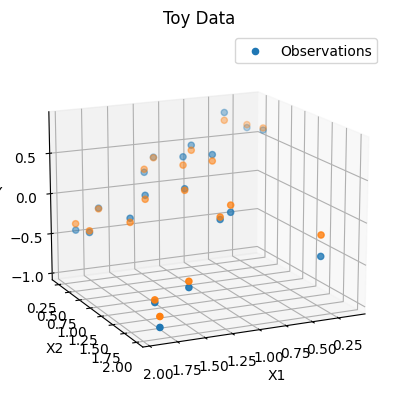

In [5]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_random_forest_model(train_X).detach().squeeze().mean(dim=-1).numpy(),
)
plt.show()

In order to use gradient-based optimization of the acquisition function (via the standard optimize_acqf() method) we will need to have the samples drawn from the posterior be differentiable w.r.t. to the input to the posterior() method (this is not the case for Random Forest models). Instead, we will perform the acquisition function optimization with gradient-free methods.



In [6]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.7849, 0.3048]]), tensor(-4.4249))

In [7]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.1638, 0.1716]]), tensor(-15.6316))